# Test the $\kappa-y$ relation

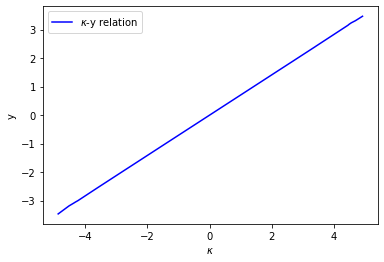

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Gaussianizaton import kappa_y_relation

## use the normal distribution to test
## the kappa-y relation should be a stright line in this case
K_test = np.random.randn(50,1024,1024)
k_test, y_test = kappa_y_relation(K_test)
plt.plot(k_test,y_test,'b-',lw=1.5,label=r'$\kappa$-y relation')
plt.xlabel(r'$\kappa$')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()


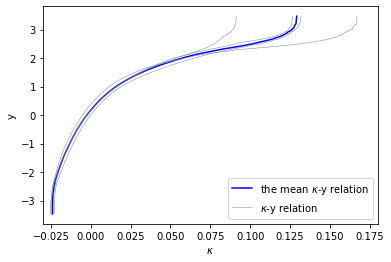

In [2]:
## load the kappa fields
Kappa = np.fromfile('data/Kappa_smooth_1.2arcmin.bin',dtype=np.float64).reshape(4,1024,1024)
k_, y_ = kappa_y_relation(Kappa)

ax = plt.subplot(1,1,1)
l0 = ax.plot(k_,y_,'b-',lw=1.5,label=r'the mean $\kappa$-y relation')
for i_f in range(4):
    ax.plot(*kappa_y_relation(Kappa[i_f,:,:]),'#778899',lw=0.5,label=r'$\kappa$-y relation')

plt.xlabel(r'$\kappa$')
plt.ylabel('y')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2],labels[0:2],loc="lower right")
plt.xlim([-0.03,0.18])
plt.show()




# Using the inverse-Gaussianization Method

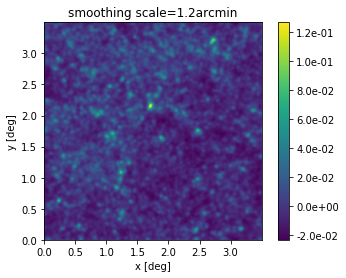

In [1]:
## load the module and the test data
from Gaussianizaton import kappa_y_relation, Gaussianization
from GeneratingNewFields import *
import matplotlib.pyplot as plt


## load the kappa fields
Kappa_original = np.fromfile('data/Kappa_smooth_1.2arcmin.bin',dtype=np.float64).reshape(4,1024,1024)

## check the simulation map
plt.imshow(Kappa_original[0,:,:],extent=([0,3.5,0,3.5]),origin='lower')
plt.xlabel("x [deg]")
plt.ylabel("y [deg]")
plt.xticks(np.arange(0,3.5,0.5))
plt.yticks(np.arange(0,3.5,0.5))
plt.colorbar(format='%.1e')
plt.grid(False)
plt.title("smoothing scale=1.2arcmin")
plt.show()


In [2]:
## Gaussianization
from scipy.interpolate import interp1d

k, y = kappa_y_relation(Kappa_original)
Y_original = Gaussianization(Kappa_original,k=k,y=y)
print("Gaussianized Fields: max value--{:1.4f}, min value--{:1.4f}".format(Y_original.max(),Y_original.min()))

i_fields = 4
bins = 500
l_y = np.zeros((bins,))
P_y = np.zeros((bins,)) 
for i_field1 in range(i_fields):
    l_y0,P_y0 = CalPy_inp(Y_original[i_field1,:,:],bins=bins)
    l_y += l_y0
    P_y += P_y0

l_y = l_y/i_fields
P_y = P_y/i_fields

Py_inp = interp1d(l_y,P_y,kind="linear")



Gaussianized Fields: max value--3.4655, min value---3.4655


In [3]:
## Generating the new Y fields and inverse-transformation
# Y_new = np.zeros((i_fields,L,L))
Kappa_new = np.zeros((i_fields,L,L))
# inverse-relation
y_2_k = interp1d(y,k,kind="linear")
ymax = y.max(); ymin = y.min()

l_min = l_y.min(); l_max = l_y.max()
for i_field2 in range(i_fields):
    Y_new0 = GeneratingNewYFields(Py_inp,l_min=l_min,l_max=l_max,size_f=L)
    Kappa_new[i_field2,:,:] = InverseTrans(Y_new0,y_2_k,y_min=ymin,y_max=ymax)

print("Convergence Realizations, max value: {:1.4f}, min value: {:1.4f}".format(Kappa_new.max(),Kappa_new.min()))


Generating the new y fields of (1024,1024).....
Generating the new y fields of (1024,1024).....
Generating the new y fields of (1024,1024).....
Generating the new y fields of (1024,1024).....
Convergence Realizations, max value: 0.1289, min value: -0.0233


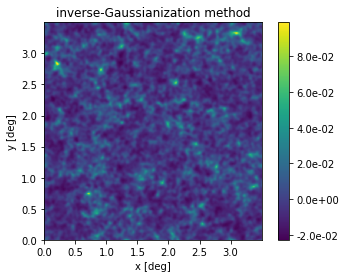

In [4]:
## check the mock map
plt.imshow(Kappa_new[0,:,:],extent=([0,3.5,0,3.5]),origin='lower')
plt.xlabel("x [deg]")
plt.ylabel("y [deg]")
plt.xticks(np.arange(0,3.5,0.5))
plt.yticks(np.arange(0,3.5,0.5))
plt.colorbar(format='%.1e')
plt.grid(False)
plt.title("inverse-Gaussianization method")
plt.show()

In [5]:
## calculate the powerspectrum
from PowerSpectrum import PowerSpectrum_2D

ell_bins = 30
Pks_original = np.zeros((i_fields,ell_bins))
Pks_new = np.zeros((i_fields,ell_bins))
for i_field3 in range(i_fields):
    ell_k1,Pks_original[i_field3,:] = PowerSpectrum_2D(Kappa_original[i_field3,:,:])
    ell_k2,Pks_new[i_field3,:] = PowerSpectrum_2D(Kappa_new[i_field3,:,:])
    

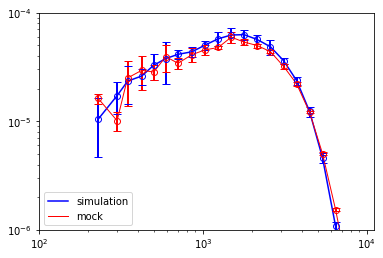

In [6]:
plt.loglog(ell_k1,np.mean(Pks_original,0),lw=1.5,color='b',label="simulation")
plt.errorbar(ell_k1,np.mean(Pks_original,0),yerr=np.std(Pks_original,0),fmt='o',ecolor='b',color='b',mfc='none',elinewidth=2,capsize=4)
plt.loglog(ell_k2,np.mean(Pks_new,0),lw=1.0,color='r',label="mock")
plt.errorbar(ell_k2,np.mean(Pks_new,0),yerr=np.std(Pks_new,0),fmt='o',ecolor='r',color='r',mfc='none',elinewidth=2,capsize=4)
plt.axis([100, 1.1e4, 1e-6, 1e-4])
plt.legend(loc="lower left")
plt.show()